## Recipe 68 Creating Features with FeatureTools

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import featuretools as ft

In [2]:
# let's load the example data set from feature tools

data_dict = ft.demo.load_mock_customer()

data = data_dict["transactions"].merge(
    data_dict["sessions"]).merge(data_dict["customers"])

cols = ['customer_id',
        'transaction_id',
        'transaction_time',
        'amount',
        ]

data = data[cols]

data.head()

,customer_id,transaction_id,transaction_time,amount
0,2,298,2014-01-01 00:00:00,127.64
1,2,2,2014-01-01 00:01:05,109.48
2,2,308,2014-01-01 00:02:10,95.06
3,2,116,2014-01-01 00:03:15,78.92
4,2,371,2014-01-01 00:04:20,31.54


In [3]:
print('Number of customers: {}'.format(data['customer_id'].nunique()))
print('Number of transactions: {}'.format(data['transaction_id'].nunique()))

Number of customers: 5
Number of transactions: 500


In [4]:
data.dtypes

customer_id                  int64
transaction_id               int64
transaction_time    datetime64[ns]
amount                     float64
dtype: object

In [5]:
# in order for feature tools to work, we need to create
# entity sets

es = ft.EntitySet(id="customer_data")

# entity set with the transactions
es = es.add_dataframe(
    dataframe_name="transactions",
    dataframe=data,
    index="transaction_id",
    time_index="transaction_time")

# display the entity set
es


Entityset: customer_data
  DataFrames:
    transactions [Rows: 500, Columns: 4]
  Relationships:
    No relationships

In [6]:
# now we indicate that within the entity set
# there is another table, with customer data,
# each customer identified with a unique
# customer id

es = es.normalize_dataframe(
    base_dataframe_name="transactions",
    new_dataframe_name="customers",
    index="customer_id")

es


Entityset: customer_data
  DataFrames:
    transactions [Rows: 500, Columns: 4]
    customers [Rows: 5, Columns: 2]
  Relationships:
    transactions.customer_id -> customers.customer_id

## Creating new features from the existing data - without aggregations

In [7]:
# featuretools automatically creates more fearures from those present in the data set
# for every single transaction, that is without aggregation

# the names in the below list, indicate featuretools to:
# 1) Create a feature from the datetime variable signalling
# if the transaction occurred on a weekend
# 2) Determines the cumulative transaction amount,
# 3) Determine the cumulative number of transactions,
# 4) Creates a new feature indicating the time since the previous transaction

# all of this operations occur at a transaction level, that is, transaction
# after transaction

transf_operations = ['is_weekend', 'cum_sum', 'cum_count','time_since_previous']

# set up the dfs from featuretools to return the previous features
# it is important to leave agg_primitives as an empty list, so that featuretools does not
# aggregate the data at a customer level as well


feature_matrix, features = ft.dfs(
    entityset=es,
    target_dataframe_name="customers",
    agg_primitives=[],
    trans_primitives=transf_operations,
    verbose=True
)
features

feature_matrix.head()

c:\Python310\lib\site-packages\featuretools\synthesis\dfs.py:321: UnusedPrimitiveWarning: Some specified primitives were not used during DFS:
  trans_primitives: ['cum_count', 'cum_sum']
This may be caused by a using a value of max_depth that is too small, not setting interesting values, or it may indicate no compatible columns for the primitive were found in the data. If the DFS call contained multiple instances of a primitive in the list above, none of them were used.
  warnings.warn(warning_msg, UnusedPrimitiveWarning)


Built 2 features
Elapsed: 00:00 | Progress: 100%|██████████


,IS_WEEKEND(first_transactions_time),TIME_SINCE_PREVIOUS(first_transactions_time)
customer_id,,
2,False,NaN
5,False,1040.0
4,False,650.0
1,False,975.0
3,False,3315.0


In [8]:
feature_matrix.head()

,IS_WEEKEND(first_transactions_time),TIME_SINCE_PREVIOUS(first_transactions_time)
customer_id,,
2,False,NaN
5,False,1040.0
4,False,650.0
1,False,975.0
3,False,3315.0


In [11]:
# let's now extract information about date and time as well

# list with the operations to perform to extract new features from the 
# existing variables
operations = ['year', 'month', 'day', 'hour', 'minute', 'second',
             'is_weekend', 'cum_sum', 'time_since_previous']


# extract tge new features

feature_matrix, features = ft.dfs(
    entityset=es,
    target_dataframe_name="transactions",
    agg_primitives=[],
    trans_primitives=operations,
    verbose=True
)


feature_matrix.head()

Built 19 features
Elapsed: 00:00 | Progress: 100%|██████████


,customer_id,amount,CUM_SUM(amount),DAY(transaction_time),HOUR(transaction_time),IS_WEEKEND(transaction_time),MINUTE(transaction_time),MONTH(transaction_time),SECOND(transaction_time),TIME_SINCE_PREVIOUS(transaction_time),YEAR(transaction_time),customers.DAY(first_transactions_time),customers.HOUR(first_transactions_time),customers.IS_WEEKEND(first_transactions_time),customers.MINUTE(first_transactions_time),customers.MONTH(first_transactions_time),customers.SECOND(first_transactions_time),customers.TIME_SINCE_PREVIOUS(first_transactions_time),customers.YEAR(first_transactions_time)
transaction_id,,,,,,,,,,,,,,,,,,,
298,2,127.64,127.64,1,0,False,0,1,0,NaN,2014,1,0,False,0,1,0,NaN,2014
2,2,109.48,237.12,1,0,False,1,1,5,65.0,2014,1,0,False,0,1,0,NaN,2014
308,2,95.06,332.18,1,0,False,2,1,10,65.0,2014,1,0,False,0,1,0,NaN,2014
116,2,78.92,411.10,1,0,False,3,1,15,65.0,2014,1,0,False,0,1,0,NaN,2014
371,2,31.54,442.64,1,0,False,4,1,20,65.0,2014,1,0,False,0,1,0,NaN,2014


In [12]:
# original dataframe and derived feature_matrix should have
# same number of observations

data.shape, feature_matrix.shape

((500, 4), (500, 19))

In [13]:
# if we don't indicate the operations to perform to create new features, featuretools will perform
# the default operations, which can be found here:

# https://docs.featuretools.com/en/stable/generated/featuretools.dfs.html#featuretools.dfs

In [14]:
# if we had more than 1 numeric feature in our dataframe, we could create new feautres by addition
# or multiplication as we did in recipe Combining multiple features with statistical operations of Chapter 9,
# Applying Mathematical Computations to Features

# for code on how to do that check this link:
# https://stackoverflow.com/questions/55155371/how-to-use-featuretools-to-create-features-for-a-single-table-with-no-immediate/55172142#55172142

In [15]:
# for more details in the types of features that we can create
# check the supported operations with the code below

primitives = ft.list_primitives()
pd.options.display.max_colwidth = 500
primitives[primitives['type'] == 'transform']

,name,type,dask_compatible,spark_compatible,description,valid_inputs,return_type
22,square_root,transform,True,True,Computes the square root of a number.,<ColumnSchema (Semantic Tags = ['numeric'])>,<ColumnSchema (Logical Type = Double) (Semantic Tags = ['numeric'])>
23,equal_scalar,transform,True,True,Determines if values in a list are equal to a given scalar.,<ColumnSchema>,<ColumnSchema (Logical Type = BooleanNullable)>
24,geomidpoint,transform,False,False,Determines the geographic center of two coordinates.,<ColumnSchema (Logical Type = LatLong)>,<ColumnSchema (Logical Type = LatLong)>
25,date_to_holiday,transform,False,False,"Transforms time of an instance into the holiday name, if there is one.",<ColumnSchema (Logical Type = Datetime)>,<ColumnSchema (Logical Type = Categorical) (Semantic Tags = ['category'])>
26,less_than_equal_to,transform,True,True,Determines if values in one list are less than or equal to another list.,"<ColumnSchema (Logical Type = Datetime)>, <ColumnSchema (Logical Type = Ordinal: None)>, <ColumnSchema (Semantic Tags = ['numeric'])>",<ColumnSchema (Logical Type = BooleanNullable)>
...,...,...,...,...,...,...,...
113,modulo_numeric_scalar,transform,True,True,Computes the modulo of each element in the list by a given scalar.,<ColumnSchema (Semantic Tags = ['numeric'])>,<ColumnSchema (Semantic Tags = ['numeric'])>
114,year,transform,True,True,Determines the year value of a datetime.,<ColumnSchema (Logical Type = Datetime)>,"<ColumnSchema (Logical Type = Ordinal: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113,..."
115,less_than_equal_to_scalar,transform,True,True,Determines if values are less than or equal to a given scalar.,"<ColumnSchema (Logical Type = Datetime)>, <ColumnSchema (Logical Type = Ordinal: None)>, <ColumnSchema (Semantic Tags = ['numeric'])>",<ColumnSchema (Logical Type = BooleanNullable)>
116,is_working_hours,transform,True,True,Determines if a datetime falls during working hours on a 24-hour clock. Can configure start_hour and end_hour.,<ColumnSchema (Logical Type = Datetime)>,<ColumnSchema (Logical Type = BooleanNullable)>


## Creating new features from the existing data - with aggregations

These are the features we can create when we want a flattened view of our dataframe, that is one row per customer.

In [16]:
# differently from the previous case, here we want to aggregate
# the information at customer level, so we want a summary view of
# each customer

# first we aggregate only the existing variables
# that is the transaction amount

# we want the mean and maximum transaction amount per customer
feature_matrix, features = ft.dfs(
    entityset=es,
    target_dataframe_name="customers",
    agg_primitives=["mean", 'max'],
    trans_primitives=[],
    verbose=True
)

# dataframe with the new features
feature_matrix

Built 2 features
Elapsed: 00:00 | Progress: 100%|██████████


,MAX(transactions.amount),MEAN(transactions.amount)
customer_id,,
2,146.81,77.422366
5,149.02,80.375443
4,149.95,80.070459
1,139.43,71.631905
3,149.15,67.060430


In [17]:
# now we will create a new feature as in the first part of the 
# notebook, and more specifically, we will create the feature
# time_since_previous transaction

# and aggregate the new feature together with the pre-existing
# variable transaction amount, all in one go

feature_matrix, features = ft.dfs(
    entityset=es,
    target_dataframe_name="customers",
    agg_primitives=["mean", 'max'],
    trans_primitives=['time_since_previous'],
    verbose=True
)


# dataframe with the new features
feature_matrix

Built 5 features
Elapsed: 00:00 | Progress: 100%|██████████


,MAX(transactions.amount),MEAN(transactions.amount),TIME_SINCE_PREVIOUS(first_transactions_time),MAX(transactions.TIME_SINCE_PREVIOUS(transaction_time)),MEAN(transactions.TIME_SINCE_PREVIOUS(transaction_time))
customer_id,,,,,
2,146.81,77.422366,NaN,65.0,65.0
5,149.02,80.375443,1040.0,65.0,65.0
4,149.95,80.070459,650.0,65.0,65.0
1,139.43,71.631905,975.0,65.0,65.0
3,149.15,67.060430,3315.0,65.0,65.0


In [18]:
# note how the final dataframe contains as many rows as 
# different customers in the data set

data.shape, feature_matrix.shape

((500, 4), (5, 5))

In [19]:
# and now let's create 2 new features and aggregate both
# together with the transaction amount

feature_matrix, features = ft.dfs(
    entityset=es,
    target_dataframe_name="customers",
    agg_primitives=["mean", 'max'],
    trans_primitives=['cum_sum','time_since_previous'],
    verbose=True
)

# dataframe with the new features
feature_matrix

Built 9 features
Elapsed: 00:00 | Progress: 100%|██████████


,MAX(transactions.amount),MEAN(transactions.amount),TIME_SINCE_PREVIOUS(first_transactions_time),MAX(transactions.CUM_SUM(amount)),MAX(transactions.TIME_SINCE_PREVIOUS(transaction_time)),MEAN(transactions.CUM_SUM(amount)),MEAN(transactions.TIME_SINCE_PREVIOUS(transaction_time)),CUM_SUM(MAX(transactions.amount)),CUM_SUM(MEAN(transactions.amount))
customer_id,,,,,,,,,
2,146.81,77.422366,NaN,35101.22,65.0,18794.182366,65.0,146.81,77.422366
5,149.02,80.375443,1040.0,34296.39,65.0,24258.206582,65.0,295.83,157.797809
4,149.95,80.070459,650.0,23418.09,65.0,12455.024495,65.0,445.78,237.868267
1,139.43,71.631905,975.0,31291.89,65.0,16566.784048,65.0,585.21,309.500172
3,149.15,67.060430,3315.0,37539.86,65.0,25387.640538,65.0,734.36,376.560602


In [20]:
data.shape, feature_matrix.shape

((500, 4), (5, 9))

## Integrating user defined functions

In the remaining lines, instead of using Featuretools pre-coded functions, we will create our own.

In [27]:
# featuretools has changed its aps fo custom primitives significantly - below  are all the imports

from featuretools.primitives import AggregationPrimitive, TransformPrimitive
from featuretools.tests.testing_utils import make_ecommerce_entityset
from woodwork.column_schema import ColumnSchema
from woodwork.logical_types import Datetime, NaturalLanguage
import pandas as pd


from scipy.signal import find_peaks

In [32]:
# define a new aggregation primitive - note the input, output types - find num  peaks

class find_no_peaks(AggregationPrimitive):
    name = "find_no_peaks"
    input_types = [ColumnSchema(semantic_tags={"numeric"})]
    return_type = ColumnSchema(semantic_tags={"numeric"})

    def get_function(self):
        def find_no_peaks(column):
            peaks, _ = find_peaks(column)
            return len(peaks)

        return find_no_peaks


In [33]:
# define a new aggregation primitive - note the input, output types - find num valleys

class find_no_valleys(AggregationPrimitive):
    name = "find_no_valleyss"
    input_types = [ColumnSchema(semantic_tags={"numeric"})]
    return_type = ColumnSchema(semantic_tags={"numeric"})

    def get_function(self):
        def find_no_valleys(column):
            valleys, _ = find_peaks(1 / column)
            return len(valleys)

        return find_no_valleys


In [34]:
# Now actually generate thefeatures 
feature_matrix, features = ft.dfs(
    entityset=es,
    target_dataframe_name="customers",
    agg_primitives=[find_no_peaks, find_no_valleys,'Mean', 'Max'],
    trans_primitives=[],
    verbose=True
)

feature_matrix

Built 4 features
Elapsed: 00:00 | Progress: 100%|██████████


,FIND_NO_PEAKS(transactions.amount),FIND_NO_VALLEYSS(transactions.amount),MAX(transactions.amount),MEAN(transactions.amount)
customer_id,,,,
2,28.0,29.0,146.81,77.422366
5,26.0,26.0,149.02,80.375443
4,37.0,38.0,149.95,80.070459
1,43.0,42.0,139.43,71.631905
3,29.0,29.0,149.15,67.060430


## Recipe 69 In this recipe, we are going to capture text complexity by creating very simple features that:

- count the number of characters
- count the number of words in the text
- count the number of unique words
- determine the lexical diversity
- determine the average word size

In [35]:
import pandas as pd

from sklearn.datasets import fetch_20newsgroups

In [36]:
# load text data
data = fetch_20newsgroups(subset='train')
df = pd.DataFrame(data.data, columns=['text'])
df.head()

,text
0,"From: lerxst@wam.umd.edu (where's my thing)\nSubject: WHAT car is this!?\nNntp-Posting-Host: rac3.wam.umd.edu\nOrganization: University of Maryland, College Park\nLines: 15\n\n I was wondering if anyone out there could enlighten me on this car I saw\nthe other day. It was a 2-door sports car, looked to be from the late 60s/\nearly 70s. It was called a Bricklin. The doors were really small. In addition,\nthe front bumper was separate from the rest of the body. This is \nall I know. If anyone ..."
1,"From: guykuo@carson.u.washington.edu (Guy Kuo)\nSubject: SI Clock Poll - Final Call\nSummary: Final call for SI clock reports\nKeywords: SI,acceleration,clock,upgrade\nArticle-I.D.: shelley.1qvfo9INNc3s\nOrganization: University of Washington\nLines: 11\nNNTP-Posting-Host: carson.u.washington.edu\n\nA fair number of brave souls who upgraded their SI clock oscillator have\nshared their experiences for this poll. Please send a brief message detailing\nyour experiences with the procedure. Top s..."
2,"From: twillis@ec.ecn.purdue.edu (Thomas E Willis)\nSubject: PB questions...\nOrganization: Purdue University Engineering Computer Network\nDistribution: usa\nLines: 36\n\nwell folks, my mac plus finally gave up the ghost this weekend after\nstarting life as a 512k way back in 1985. sooo, i'm in the market for a\nnew machine a bit sooner than i intended to be...\n\ni'm looking into picking up a powerbook 160 or maybe 180 and have a bunch\nof questions that (hopefully) somebody can answer:\n\..."
3,"From: jgreen@amber (Joe Green)\nSubject: Re: Weitek P9000 ?\nOrganization: Harris Computer Systems Division\nLines: 14\nDistribution: world\nNNTP-Posting-Host: amber.ssd.csd.harris.com\nX-Newsreader: TIN [version 1.1 PL9]\n\nRobert J.C. Kyanko (rob@rjck.UUCP) wrote:\n> abraxis@iastate.edu writes in article <abraxis.734340159@class1.iastate.edu>:\n> > Anyone know about the Weitek P9000 graphics chip?\n> As far as the low-level stuff goes, it looks pretty nice. It's got this\n> quadrilateral ..."
4,"From: jcm@head-cfa.harvard.edu (Jonathan McDowell)\nSubject: Re: Shuttle Launch Question\nOrganization: Smithsonian Astrophysical Observatory, Cambridge, MA, USA\nDistribution: sci\nLines: 23\n\nFrom article <C5owCB.n3p@world.std.com>, by tombaker@world.std.com (Tom A Baker):\n>>In article <C5JLwx.4H9.1@cs.cmu.edu>, ETRAT@ttacs1.ttu.edu (Pack Rat) writes...\n>>>""Clear caution & warning memory. Verify no unexpected\n>>>errors. ..."". I am wondering what an ""expected error"" might\n>>>be. So..."


# Counting number of characters

In [37]:
df['num_char'] = df['text'].str.len()

df.head()

,text,num_char
0,"From: lerxst@wam.umd.edu (where's my thing)\nSubject: WHAT car is this!?\nNntp-Posting-Host: rac3.wam.umd.edu\nOrganization: University of Maryland, College Park\nLines: 15\n\n I was wondering if anyone out there could enlighten me on this car I saw\nthe other day. It was a 2-door sports car, looked to be from the late 60s/\nearly 70s. It was called a Bricklin. The doors were really small. In addition,\nthe front bumper was separate from the rest of the body. This is \nall I know. If anyone ...",721
1,"From: guykuo@carson.u.washington.edu (Guy Kuo)\nSubject: SI Clock Poll - Final Call\nSummary: Final call for SI clock reports\nKeywords: SI,acceleration,clock,upgrade\nArticle-I.D.: shelley.1qvfo9INNc3s\nOrganization: University of Washington\nLines: 11\nNNTP-Posting-Host: carson.u.washington.edu\n\nA fair number of brave souls who upgraded their SI clock oscillator have\nshared their experiences for this poll. Please send a brief message detailing\nyour experiences with the procedure. Top s...",858
2,"From: twillis@ec.ecn.purdue.edu (Thomas E Willis)\nSubject: PB questions...\nOrganization: Purdue University Engineering Computer Network\nDistribution: usa\nLines: 36\n\nwell folks, my mac plus finally gave up the ghost this weekend after\nstarting life as a 512k way back in 1985. sooo, i'm in the market for a\nnew machine a bit sooner than i intended to be...\n\ni'm looking into picking up a powerbook 160 or maybe 180 and have a bunch\nof questions that (hopefully) somebody can answer:\n\...",1981
3,"From: jgreen@amber (Joe Green)\nSubject: Re: Weitek P9000 ?\nOrganization: Harris Computer Systems Division\nLines: 14\nDistribution: world\nNNTP-Posting-Host: amber.ssd.csd.harris.com\nX-Newsreader: TIN [version 1.1 PL9]\n\nRobert J.C. Kyanko (rob@rjck.UUCP) wrote:\n> abraxis@iastate.edu writes in article <abraxis.734340159@class1.iastate.edu>:\n> > Anyone know about the Weitek P9000 graphics chip?\n> As far as the low-level stuff goes, it looks pretty nice. It's got this\n> quadrilateral ...",815
4,"From: jcm@head-cfa.harvard.edu (Jonathan McDowell)\nSubject: Re: Shuttle Launch Question\nOrganization: Smithsonian Astrophysical Observatory, Cambridge, MA, USA\nDistribution: sci\nLines: 23\n\nFrom article <C5owCB.n3p@world.std.com>, by tombaker@world.std.com (Tom A Baker):\n>>In article <C5JLwx.4H9.1@cs.cmu.edu>, ETRAT@ttacs1.ttu.edu (Pack Rat) writes...\n>>>""Clear caution & warning memory. Verify no unexpected\n>>>errors. ..."". I am wondering what an ""expected error"" might\n>>>be. So...",1120


In [38]:
# same but removing trailing white spaces
df['num_char'] = df['text'].str.strip().str.len()

df.head()

,text,num_char
0,"From: lerxst@wam.umd.edu (where's my thing)\nSubject: WHAT car is this!?\nNntp-Posting-Host: rac3.wam.umd.edu\nOrganization: University of Maryland, College Park\nLines: 15\n\n I was wondering if anyone out there could enlighten me on this car I saw\nthe other day. It was a 2-door sports car, looked to be from the late 60s/\nearly 70s. It was called a Bricklin. The doors were really small. In addition,\nthe front bumper was separate from the rest of the body. This is \nall I know. If anyone ...",716
1,"From: guykuo@carson.u.washington.edu (Guy Kuo)\nSubject: SI Clock Poll - Final Call\nSummary: Final call for SI clock reports\nKeywords: SI,acceleration,clock,upgrade\nArticle-I.D.: shelley.1qvfo9INNc3s\nOrganization: University of Washington\nLines: 11\nNNTP-Posting-Host: carson.u.washington.edu\n\nA fair number of brave souls who upgraded their SI clock oscillator have\nshared their experiences for this poll. Please send a brief message detailing\nyour experiences with the procedure. Top s...",857
2,"From: twillis@ec.ecn.purdue.edu (Thomas E Willis)\nSubject: PB questions...\nOrganization: Purdue University Engineering Computer Network\nDistribution: usa\nLines: 36\n\nwell folks, my mac plus finally gave up the ghost this weekend after\nstarting life as a 512k way back in 1985. sooo, i'm in the market for a\nnew machine a bit sooner than i intended to be...\n\ni'm looking into picking up a powerbook 160 or maybe 180 and have a bunch\nof questions that (hopefully) somebody can answer:\n\...",1980
3,"From: jgreen@amber (Joe Green)\nSubject: Re: Weitek P9000 ?\nOrganization: Harris Computer Systems Division\nLines: 14\nDistribution: world\nNNTP-Posting-Host: amber.ssd.csd.harris.com\nX-Newsreader: TIN [version 1.1 PL9]\n\nRobert J.C. Kyanko (rob@rjck.UUCP) wrote:\n> abraxis@iastate.edu writes in article <abraxis.734340159@class1.iastate.edu>:\n> > Anyone know about the Weitek P9000 graphics chip?\n> As far as the low-level stuff goes, it looks pretty nice. It's got this\n> quadrilateral ...",814
4,"From: jcm@head-cfa.harvard.edu (Jonathan McDowell)\nSubject: Re: Shuttle Launch Question\nOrganization: Smithsonian Astrophysical Observatory, Cambridge, MA, USA\nDistribution: sci\nLines: 23\n\nFrom article <C5owCB.n3p@world.std.com>, by tombaker@world.std.com (Tom A Baker):\n>>In article <C5JLwx.4H9.1@cs.cmu.edu>, ETRAT@ttacs1.ttu.edu (Pack Rat) writes...\n>>>""Clear caution & warning memory. Verify no unexpected\n>>>errors. ..."". I am wondering what an ""expected error"" might\n>>>be. So...",1117


# Counting number of words

In [39]:
df['num_words'] = df['text'].str.split().str.len()

df.head()

,text,num_char,num_words
0,"From: lerxst@wam.umd.edu (where's my thing)\nSubject: WHAT car is this!?\nNntp-Posting-Host: rac3.wam.umd.edu\nOrganization: University of Maryland, College Park\nLines: 15\n\n I was wondering if anyone out there could enlighten me on this car I saw\nthe other day. It was a 2-door sports car, looked to be from the late 60s/\nearly 70s. It was called a Bricklin. The doors were really small. In addition,\nthe front bumper was separate from the rest of the body. This is \nall I know. If anyone ...",716,123
1,"From: guykuo@carson.u.washington.edu (Guy Kuo)\nSubject: SI Clock Poll - Final Call\nSummary: Final call for SI clock reports\nKeywords: SI,acceleration,clock,upgrade\nArticle-I.D.: shelley.1qvfo9INNc3s\nOrganization: University of Washington\nLines: 11\nNNTP-Posting-Host: carson.u.washington.edu\n\nA fair number of brave souls who upgraded their SI clock oscillator have\nshared their experiences for this poll. Please send a brief message detailing\nyour experiences with the procedure. Top s...",857,123
2,"From: twillis@ec.ecn.purdue.edu (Thomas E Willis)\nSubject: PB questions...\nOrganization: Purdue University Engineering Computer Network\nDistribution: usa\nLines: 36\n\nwell folks, my mac plus finally gave up the ghost this weekend after\nstarting life as a 512k way back in 1985. sooo, i'm in the market for a\nnew machine a bit sooner than i intended to be...\n\ni'm looking into picking up a powerbook 160 or maybe 180 and have a bunch\nof questions that (hopefully) somebody can answer:\n\...",1980,339
3,"From: jgreen@amber (Joe Green)\nSubject: Re: Weitek P9000 ?\nOrganization: Harris Computer Systems Division\nLines: 14\nDistribution: world\nNNTP-Posting-Host: amber.ssd.csd.harris.com\nX-Newsreader: TIN [version 1.1 PL9]\n\nRobert J.C. Kyanko (rob@rjck.UUCP) wrote:\n> abraxis@iastate.edu writes in article <abraxis.734340159@class1.iastate.edu>:\n> > Anyone know about the Weitek P9000 graphics chip?\n> As far as the low-level stuff goes, it looks pretty nice. It's got this\n> quadrilateral ...",814,113
4,"From: jcm@head-cfa.harvard.edu (Jonathan McDowell)\nSubject: Re: Shuttle Launch Question\nOrganization: Smithsonian Astrophysical Observatory, Cambridge, MA, USA\nDistribution: sci\nLines: 23\n\nFrom article <C5owCB.n3p@world.std.com>, by tombaker@world.std.com (Tom A Baker):\n>>In article <C5JLwx.4H9.1@cs.cmu.edu>, ETRAT@ttacs1.ttu.edu (Pack Rat) writes...\n>>>""Clear caution & warning memory. Verify no unexpected\n>>>errors. ..."". I am wondering what an ""expected error"" might\n>>>be. So...",1117,171


In [40]:
# same but removing trailing white spaces
df['num_words'] = df['text'].str.strip().str.split().str.len()

df.head()

,text,num_char,num_words
0,"From: lerxst@wam.umd.edu (where's my thing)\nSubject: WHAT car is this!?\nNntp-Posting-Host: rac3.wam.umd.edu\nOrganization: University of Maryland, College Park\nLines: 15\n\n I was wondering if anyone out there could enlighten me on this car I saw\nthe other day. It was a 2-door sports car, looked to be from the late 60s/\nearly 70s. It was called a Bricklin. The doors were really small. In addition,\nthe front bumper was separate from the rest of the body. This is \nall I know. If anyone ...",716,123
1,"From: guykuo@carson.u.washington.edu (Guy Kuo)\nSubject: SI Clock Poll - Final Call\nSummary: Final call for SI clock reports\nKeywords: SI,acceleration,clock,upgrade\nArticle-I.D.: shelley.1qvfo9INNc3s\nOrganization: University of Washington\nLines: 11\nNNTP-Posting-Host: carson.u.washington.edu\n\nA fair number of brave souls who upgraded their SI clock oscillator have\nshared their experiences for this poll. Please send a brief message detailing\nyour experiences with the procedure. Top s...",857,123
2,"From: twillis@ec.ecn.purdue.edu (Thomas E Willis)\nSubject: PB questions...\nOrganization: Purdue University Engineering Computer Network\nDistribution: usa\nLines: 36\n\nwell folks, my mac plus finally gave up the ghost this weekend after\nstarting life as a 512k way back in 1985. sooo, i'm in the market for a\nnew machine a bit sooner than i intended to be...\n\ni'm looking into picking up a powerbook 160 or maybe 180 and have a bunch\nof questions that (hopefully) somebody can answer:\n\...",1980,339
3,"From: jgreen@amber (Joe Green)\nSubject: Re: Weitek P9000 ?\nOrganization: Harris Computer Systems Division\nLines: 14\nDistribution: world\nNNTP-Posting-Host: amber.ssd.csd.harris.com\nX-Newsreader: TIN [version 1.1 PL9]\n\nRobert J.C. Kyanko (rob@rjck.UUCP) wrote:\n> abraxis@iastate.edu writes in article <abraxis.734340159@class1.iastate.edu>:\n> > Anyone know about the Weitek P9000 graphics chip?\n> As far as the low-level stuff goes, it looks pretty nice. It's got this\n> quadrilateral ...",814,113
4,"From: jcm@head-cfa.harvard.edu (Jonathan McDowell)\nSubject: Re: Shuttle Launch Question\nOrganization: Smithsonian Astrophysical Observatory, Cambridge, MA, USA\nDistribution: sci\nLines: 23\n\nFrom article <C5owCB.n3p@world.std.com>, by tombaker@world.std.com (Tom A Baker):\n>>In article <C5JLwx.4H9.1@cs.cmu.edu>, ETRAT@ttacs1.ttu.edu (Pack Rat) writes...\n>>>""Clear caution & warning memory. Verify no unexpected\n>>>errors. ..."". I am wondering what an ""expected error"" might\n>>>be. So...",1117,171


## Determine vocabulary

In [41]:
df['num_vocab'] = df['text'].str.split().apply(set).str.len()

df.head()

,text,num_char,num_words,num_vocab
0,"From: lerxst@wam.umd.edu (where's my thing)\nSubject: WHAT car is this!?\nNntp-Posting-Host: rac3.wam.umd.edu\nOrganization: University of Maryland, College Park\nLines: 15\n\n I was wondering if anyone out there could enlighten me on this car I saw\nthe other day. It was a 2-door sports car, looked to be from the late 60s/\nearly 70s. It was called a Bricklin. The doors were really small. In addition,\nthe front bumper was separate from the rest of the body. This is \nall I know. If anyone ...",716,123,96
1,"From: guykuo@carson.u.washington.edu (Guy Kuo)\nSubject: SI Clock Poll - Final Call\nSummary: Final call for SI clock reports\nKeywords: SI,acceleration,clock,upgrade\nArticle-I.D.: shelley.1qvfo9INNc3s\nOrganization: University of Washington\nLines: 11\nNNTP-Posting-Host: carson.u.washington.edu\n\nA fair number of brave souls who upgraded their SI clock oscillator have\nshared their experiences for this poll. Please send a brief message detailing\nyour experiences with the procedure. Top s...",857,123,103
2,"From: twillis@ec.ecn.purdue.edu (Thomas E Willis)\nSubject: PB questions...\nOrganization: Purdue University Engineering Computer Network\nDistribution: usa\nLines: 36\n\nwell folks, my mac plus finally gave up the ghost this weekend after\nstarting life as a 512k way back in 1985. sooo, i'm in the market for a\nnew machine a bit sooner than i intended to be...\n\ni'm looking into picking up a powerbook 160 or maybe 180 and have a bunch\nof questions that (hopefully) somebody can answer:\n\...",1980,339,220
3,"From: jgreen@amber (Joe Green)\nSubject: Re: Weitek P9000 ?\nOrganization: Harris Computer Systems Division\nLines: 14\nDistribution: world\nNNTP-Posting-Host: amber.ssd.csd.harris.com\nX-Newsreader: TIN [version 1.1 PL9]\n\nRobert J.C. Kyanko (rob@rjck.UUCP) wrote:\n> abraxis@iastate.edu writes in article <abraxis.734340159@class1.iastate.edu>:\n> > Anyone know about the Weitek P9000 graphics chip?\n> As far as the low-level stuff goes, it looks pretty nice. It's got this\n> quadrilateral ...",814,113,97
4,"From: jcm@head-cfa.harvard.edu (Jonathan McDowell)\nSubject: Re: Shuttle Launch Question\nOrganization: Smithsonian Astrophysical Observatory, Cambridge, MA, USA\nDistribution: sci\nLines: 23\n\nFrom article <C5owCB.n3p@world.std.com>, by tombaker@world.std.com (Tom A Baker):\n>>In article <C5JLwx.4H9.1@cs.cmu.edu>, ETRAT@ttacs1.ttu.edu (Pack Rat) writes...\n>>>""Clear caution & warning memory. Verify no unexpected\n>>>errors. ..."". I am wondering what an ""expected error"" might\n>>>be. So...",1117,171,140


In [42]:
# setting charaters to lower case before counting unique words

df['num_vocab'] = df['text'].str.lower().str.split().apply(set).str.len()

df.head()

,text,num_char,num_words,num_vocab
0,"From: lerxst@wam.umd.edu (where's my thing)\nSubject: WHAT car is this!?\nNntp-Posting-Host: rac3.wam.umd.edu\nOrganization: University of Maryland, College Park\nLines: 15\n\n I was wondering if anyone out there could enlighten me on this car I saw\nthe other day. It was a 2-door sports car, looked to be from the late 60s/\nearly 70s. It was called a Bricklin. The doors were really small. In addition,\nthe front bumper was separate from the rest of the body. This is \nall I know. If anyone ...",716,123,93
1,"From: guykuo@carson.u.washington.edu (Guy Kuo)\nSubject: SI Clock Poll - Final Call\nSummary: Final call for SI clock reports\nKeywords: SI,acceleration,clock,upgrade\nArticle-I.D.: shelley.1qvfo9INNc3s\nOrganization: University of Washington\nLines: 11\nNNTP-Posting-Host: carson.u.washington.edu\n\nA fair number of brave souls who upgraded their SI clock oscillator have\nshared their experiences for this poll. Please send a brief message detailing\nyour experiences with the procedure. Top s...",857,123,99
2,"From: twillis@ec.ecn.purdue.edu (Thomas E Willis)\nSubject: PB questions...\nOrganization: Purdue University Engineering Computer Network\nDistribution: usa\nLines: 36\n\nwell folks, my mac plus finally gave up the ghost this weekend after\nstarting life as a 512k way back in 1985. sooo, i'm in the market for a\nnew machine a bit sooner than i intended to be...\n\ni'm looking into picking up a powerbook 160 or maybe 180 and have a bunch\nof questions that (hopefully) somebody can answer:\n\...",1980,339,219
3,"From: jgreen@amber (Joe Green)\nSubject: Re: Weitek P9000 ?\nOrganization: Harris Computer Systems Division\nLines: 14\nDistribution: world\nNNTP-Posting-Host: amber.ssd.csd.harris.com\nX-Newsreader: TIN [version 1.1 PL9]\n\nRobert J.C. Kyanko (rob@rjck.UUCP) wrote:\n> abraxis@iastate.edu writes in article <abraxis.734340159@class1.iastate.edu>:\n> > Anyone know about the Weitek P9000 graphics chip?\n> As far as the low-level stuff goes, it looks pretty nice. It's got this\n> quadrilateral ...",814,113,96
4,"From: jcm@head-cfa.harvard.edu (Jonathan McDowell)\nSubject: Re: Shuttle Launch Question\nOrganization: Smithsonian Astrophysical Observatory, Cambridge, MA, USA\nDistribution: sci\nLines: 23\n\nFrom article <C5owCB.n3p@world.std.com>, by tombaker@world.std.com (Tom A Baker):\n>>In article <C5JLwx.4H9.1@cs.cmu.edu>, ETRAT@ttacs1.ttu.edu (Pack Rat) writes...\n>>>""Clear caution & warning memory. Verify no unexpected\n>>>errors. ..."". I am wondering what an ""expected error"" might\n>>>be. So...",1117,171,139


## Lexical diversity

In [43]:
df['lexical_div'] = df['num_words'] / df['num_vocab']

df.head()

,text,num_char,num_words,num_vocab,lexical_div
0,"From: lerxst@wam.umd.edu (where's my thing)\nSubject: WHAT car is this!?\nNntp-Posting-Host: rac3.wam.umd.edu\nOrganization: University of Maryland, College Park\nLines: 15\n\n I was wondering if anyone out there could enlighten me on this car I saw\nthe other day. It was a 2-door sports car, looked to be from the late 60s/\nearly 70s. It was called a Bricklin. The doors were really small. In addition,\nthe front bumper was separate from the rest of the body. This is \nall I know. If anyone ...",716,123,93,1.322581
1,"From: guykuo@carson.u.washington.edu (Guy Kuo)\nSubject: SI Clock Poll - Final Call\nSummary: Final call for SI clock reports\nKeywords: SI,acceleration,clock,upgrade\nArticle-I.D.: shelley.1qvfo9INNc3s\nOrganization: University of Washington\nLines: 11\nNNTP-Posting-Host: carson.u.washington.edu\n\nA fair number of brave souls who upgraded their SI clock oscillator have\nshared their experiences for this poll. Please send a brief message detailing\nyour experiences with the procedure. Top s...",857,123,99,1.242424
2,"From: twillis@ec.ecn.purdue.edu (Thomas E Willis)\nSubject: PB questions...\nOrganization: Purdue University Engineering Computer Network\nDistribution: usa\nLines: 36\n\nwell folks, my mac plus finally gave up the ghost this weekend after\nstarting life as a 512k way back in 1985. sooo, i'm in the market for a\nnew machine a bit sooner than i intended to be...\n\ni'm looking into picking up a powerbook 160 or maybe 180 and have a bunch\nof questions that (hopefully) somebody can answer:\n\...",1980,339,219,1.547945
3,"From: jgreen@amber (Joe Green)\nSubject: Re: Weitek P9000 ?\nOrganization: Harris Computer Systems Division\nLines: 14\nDistribution: world\nNNTP-Posting-Host: amber.ssd.csd.harris.com\nX-Newsreader: TIN [version 1.1 PL9]\n\nRobert J.C. Kyanko (rob@rjck.UUCP) wrote:\n> abraxis@iastate.edu writes in article <abraxis.734340159@class1.iastate.edu>:\n> > Anyone know about the Weitek P9000 graphics chip?\n> As far as the low-level stuff goes, it looks pretty nice. It's got this\n> quadrilateral ...",814,113,96,1.177083
4,"From: jcm@head-cfa.harvard.edu (Jonathan McDowell)\nSubject: Re: Shuttle Launch Question\nOrganization: Smithsonian Astrophysical Observatory, Cambridge, MA, USA\nDistribution: sci\nLines: 23\n\nFrom article <C5owCB.n3p@world.std.com>, by tombaker@world.std.com (Tom A Baker):\n>>In article <C5JLwx.4H9.1@cs.cmu.edu>, ETRAT@ttacs1.ttu.edu (Pack Rat) writes...\n>>>""Clear caution & warning memory. Verify no unexpected\n>>>errors. ..."". I am wondering what an ""expected error"" might\n>>>be. So...",1117,171,139,1.230216


## Average words length

In [44]:
df['ave_word_length'] = df['num_char'] / df['num_words']

df.head()

,text,num_char,num_words,num_vocab,lexical_div,ave_word_length
0,"From: lerxst@wam.umd.edu (where's my thing)\nSubject: WHAT car is this!?\nNntp-Posting-Host: rac3.wam.umd.edu\nOrganization: University of Maryland, College Park\nLines: 15\n\n I was wondering if anyone out there could enlighten me on this car I saw\nthe other day. It was a 2-door sports car, looked to be from the late 60s/\nearly 70s. It was called a Bricklin. The doors were really small. In addition,\nthe front bumper was separate from the rest of the body. This is \nall I know. If anyone ...",716,123,93,1.322581,5.821138
1,"From: guykuo@carson.u.washington.edu (Guy Kuo)\nSubject: SI Clock Poll - Final Call\nSummary: Final call for SI clock reports\nKeywords: SI,acceleration,clock,upgrade\nArticle-I.D.: shelley.1qvfo9INNc3s\nOrganization: University of Washington\nLines: 11\nNNTP-Posting-Host: carson.u.washington.edu\n\nA fair number of brave souls who upgraded their SI clock oscillator have\nshared their experiences for this poll. Please send a brief message detailing\nyour experiences with the procedure. Top s...",857,123,99,1.242424,6.967480
2,"From: twillis@ec.ecn.purdue.edu (Thomas E Willis)\nSubject: PB questions...\nOrganization: Purdue University Engineering Computer Network\nDistribution: usa\nLines: 36\n\nwell folks, my mac plus finally gave up the ghost this weekend after\nstarting life as a 512k way back in 1985. sooo, i'm in the market for a\nnew machine a bit sooner than i intended to be...\n\ni'm looking into picking up a powerbook 160 or maybe 180 and have a bunch\nof questions that (hopefully) somebody can answer:\n\...",1980,339,219,1.547945,5.840708
3,"From: jgreen@amber (Joe Green)\nSubject: Re: Weitek P9000 ?\nOrganization: Harris Computer Systems Division\nLines: 14\nDistribution: world\nNNTP-Posting-Host: amber.ssd.csd.harris.com\nX-Newsreader: TIN [version 1.1 PL9]\n\nRobert J.C. Kyanko (rob@rjck.UUCP) wrote:\n> abraxis@iastate.edu writes in article <abraxis.734340159@class1.iastate.edu>:\n> > Anyone know about the Weitek P9000 graphics chip?\n> As far as the low-level stuff goes, it looks pretty nice. It's got this\n> quadrilateral ...",814,113,96,1.177083,7.203540
4,"From: jcm@head-cfa.harvard.edu (Jonathan McDowell)\nSubject: Re: Shuttle Launch Question\nOrganization: Smithsonian Astrophysical Observatory, Cambridge, MA, USA\nDistribution: sci\nLines: 23\n\nFrom article <C5owCB.n3p@world.std.com>, by tombaker@world.std.com (Tom A Baker):\n>>In article <C5JLwx.4H9.1@cs.cmu.edu>, ETRAT@ttacs1.ttu.edu (Pack Rat) writes...\n>>>""Clear caution & warning memory. Verify no unexpected\n>>>errors. ..."". I am wondering what an ""expected error"" might\n>>>be. So...",1117,171,139,1.230216,6.532164


## There is more...

Let's explore how the distribution of the created features varies across the different topics the text refers to.

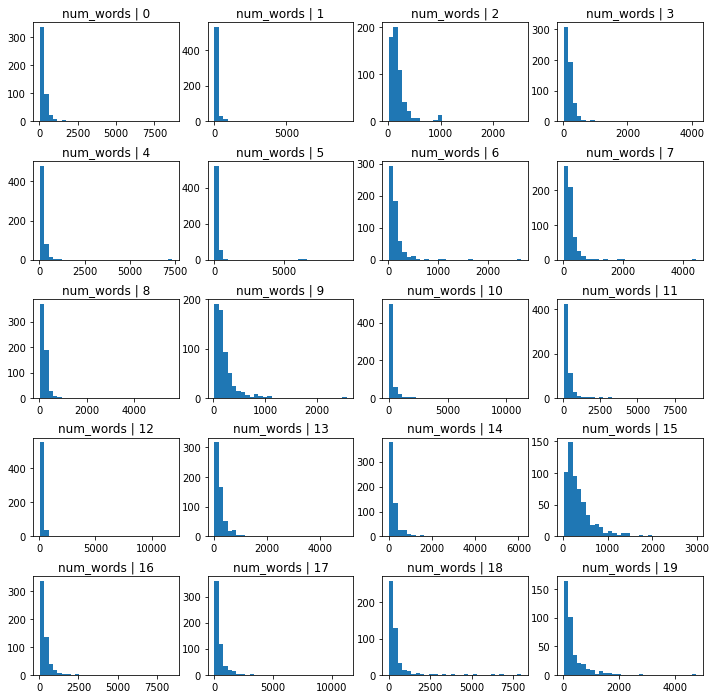

In [45]:
import matplotlib.pyplot as plt

df['target'] = data.target

def plot_features(df, text_var):

    # function plots 9 images
    nb_rows = 5
    nb_cols = 4
    
    fig, axs = plt.subplots(nb_rows, nb_cols, figsize=(12, 12))
    plt.subplots_adjust(wspace=None, hspace=0.4)

    n = 0
    for i in range(0, nb_rows):
        for j in range(0, nb_cols):
            axs[i, j].hist(df[df.target==n][text_var], bins=30)
            axs[i, j].set_title(text_var + ' | ' + str(n))
            n += 1
    plt.show()
    
plot_features(df, 'num_words')

## Recipe 70 - Sentence Counting features

In [1]:
import pandas as pd
from nltk.tokenize import sent_tokenize

from sklearn.datasets import fetch_20newsgroups

In [3]:
text = """
A fair number of brave souls who upgraded their SI clock oscillator have
shared their experiences for this poll. Please send a brief message detailing
your experiences with the procedure. Top speed attained, CPU rated speed,
add on cards and adapters, heat sinks, hour of usage per day, floppy disk
functionality with 800 and 1.4 m floppies are especially requested.

I will be summarizing in the next two days, so please add to the network
knowledge base if you have done the clock upgrade and haven't answered this
poll. Thanks.
"""

In [4]:
# separate text into sentences

sent_tokenize(text)

['\nA fair number of brave souls who upgraded their SI clock oscillator have\nshared their experiences for this poll.',
 'Please send a brief message detailing\nyour experiences with the procedure.',
 'Top speed attained, CPU rated speed,\nadd on cards and adapters, heat sinks, hour of usage per day, floppy disk\nfunctionality with 800 and 1.4 m floppies are especially requested.',
 "I will be summarizing in the next two days, so please add to the network\nknowledge base if you have done the clock upgrade and haven't answered this\npoll.",
 'Thanks.']

In [6]:
# count number of sentences

len(sent_tokenize(text))

5

In [7]:
# now we do the same for an entire dataframe

# load data
data = fetch_20newsgroups(subset='train')
df = pd.DataFrame(data.data, columns=['text'])
df.head()

,text
0,From: lerxst@wam.umd.edu (where's my thing)\nS...
1,From: guykuo@carson.u.washington.edu (Guy Kuo)...
2,From: twillis@ec.ecn.purdue.edu (Thomas E Will...
3,From: jgreen@amber (Joe Green)\nSubject: Re: W...
4,From: jcm@head-cfa.harvard.edu (Jonathan McDow...


In [8]:
# take the first 10 rows to speed things up

df = df.loc[1:10]
df

,text
1,From: guykuo@carson.u.washington.edu (Guy Kuo)...
2,From: twillis@ec.ecn.purdue.edu (Thomas E Will...
3,From: jgreen@amber (Joe Green)\nSubject: Re: W...
4,From: jcm@head-cfa.harvard.edu (Jonathan McDow...
5,From: dfo@vttoulu.tko.vtt.fi (Foxvog Douglas)\...
6,From: bmdelane@quads.uchicago.edu (brian manni...
7,From: bgrubb@dante.nmsu.edu (GRUBB)\nSubject: ...
8,From: holmes7000@iscsvax.uni.edu\nSubject: WIn...
9,From: kerr@ux1.cso.uiuc.edu (Stan Kerr)\nSubje...
10,From: irwin@cmptrc.lonestar.org (Irwin Arnstei...


In [9]:
# remove first part of email

df['text'] = df['text'].str.split('Lines:').apply(lambda x: x[1])

df

,text
1,11\nNNTP-Posting-Host: carson.u.washington.ed...
2,"36\n\nwell folks, my mac plus finally gave up..."
3,14\nDistribution: world\nNNTP-Posting-Host: a...
4,23\n\nFrom article <C5owCB.n3p@world.std.com>...
5,58\n\nIn article <1r1eu1$4t@transfer.stratus....
6,12\n\nThere were a few people who responded t...
7,44\nDistribution: world\nNNTP-Posting-Host: d...
8,10\n\nI have win 3.0 and downloaded several i...
9,29\n\njap10@po.CWRU.Edu (Joseph A. Pellettier...
10,13\n\nI have a line on a Ducati 900GTS 1978 m...


In [10]:
print(df['text'][1])

 11
NNTP-Posting-Host: carson.u.washington.edu

A fair number of brave souls who upgraded their SI clock oscillator have
shared their experiences for this poll. Please send a brief message detailing
your experiences with the procedure. Top speed attained, CPU rated speed,
add on cards and adapters, heat sinks, hour of usage per day, floppy disk
functionality with 800 and 1.4 m floppies are especially requested.

I will be summarizing in the next two days, so please add to the network
knowledge base if you have done the clock upgrade and haven't answered this
poll. Thanks.

Guy Kuo <guykuo@u.washington.edu>



In [11]:
df['num_sent'] = df['text'].apply(sent_tokenize).apply(len)

df

,text,num_sent
1,11\nNNTP-Posting-Host: carson.u.washington.ed...,6
2,"36\n\nwell folks, my mac plus finally gave up...",9
3,14\nDistribution: world\nNNTP-Posting-Host: a...,7
4,23\n\nFrom article <C5owCB.n3p@world.std.com>...,10
5,58\n\nIn article <1r1eu1$4t@transfer.stratus....,21
6,12\n\nThere were a few people who responded t...,8
7,44\nDistribution: world\nNNTP-Posting-Host: d...,15
8,10\n\nI have win 3.0 and downloaded several i...,3
9,29\n\njap10@po.CWRU.Edu (Joseph A. Pellettier...,12
10,13\n\nI have a line on a Ducati 900GTS 1978 m...,11


## Recipe 71 - Bag of words

In [12]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer

In [13]:
# load data
data = fetch_20newsgroups(subset='train')
df = pd.DataFrame(data.data, columns=['text'])
df.head()

,text
0,From: lerxst@wam.umd.edu (where's my thing)\nS...
1,From: guykuo@carson.u.washington.edu (Guy Kuo)...
2,From: twillis@ec.ecn.purdue.edu (Thomas E Will...
3,From: jgreen@amber (Joe Green)\nSubject: Re: W...
4,From: jcm@head-cfa.harvard.edu (Jonathan McDow...


In [14]:
# remove punctuation and numbers

df['text'] = df['text'].str.replace('[^\w\s]','').str.replace('\d+', '')

C:\Users\Arindam Banerji\AppData\Local\Temp\ipykernel_26328\353454803.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  df['text'] = df['text'].str.replace('[^\w\s]','').str.replace('\d+', '')


In [15]:
# set up a bag of words transformer

vectorizer = CountVectorizer(lowercase=True,
                             stop_words='english',
                             ngram_range=(1, 1),
                             min_df=0.05)

In [16]:
# transformer finds the words to be retained

vectorizer.fit(df['text'])

CountVectorizer(min_df=0.05, stop_words='english')

In [17]:
X = vectorizer.transform(df['text'])

In [18]:
# create bago of words dataframe

bagofwords = pd.DataFrame(X.toarray(),
                          columns = vectorizer.get_feature_names())

bagofwords.head()

c:\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,able,access,actually,ago,apr,article,articleid,ask,available,away,...,works,world,writes,wrong,wrote,xnewsreader,year,years,yes,youre
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,...,0,1,1,0,1,1,0,0,0,0
4,0,0,0,0,0,2,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0


In [19]:
bagofwords.shape

(11314, 191)

In [20]:
# with n grams
vectorizer = CountVectorizer(lowercase=True,
                             stop_words='english',
                             ngram_range=(1, 2),
                             min_df=0.1)

In [21]:
vectorizer.fit(df['text'])

CountVectorizer(min_df=0.1, ngram_range=(1, 2), stop_words='english')

In [22]:
X = vectorizer.transform(df['text'])

In [23]:
bagofwords = pd.DataFrame(X.toarray(),
                          columns = vectorizer.get_feature_names())

bagofwords.head()

c:\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,article,believe,better,case,computer,did,distribution,does,doesnt,dont,...,use,used,using,want,way,work,world,writes,writes article,years
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,2,0,1,2,0,2,...,1,0,0,0,1,0,0,0,0,0
3,1,0,0,0,2,0,1,0,0,0,...,0,0,0,0,0,0,1,1,1,0
4,2,0,0,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,1,0,0


In [24]:
vectorizer.get_feature_names()

c:\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


['article',
 'believe',
 'better',
 'case',
 'computer',
 'did',
 'distribution',
 'does',
 'doesnt',
 'dont',
 'email',
 'going',
 'good',
 'got',
 'help',
 'im',
 'ive',
 'just',
 'know',
 'like',
 'lines',
 'lines article',
 'lines nntppostinghost',
 'make',
 'need',
 'new',
 'nntppostinghost',
 'organization',
 'organization university',
 'people',
 'point',
 'problem',
 'question',
 'read',
 'really',
 'replyto',
 'right',
 'said',
 'say',
 'state',
 'subject',
 'sure',
 'thanks',
 'thing',
 'things',
 'think',
 'time',
 'university',
 'usa',
 'use',
 'used',
 'using',
 'want',
 'way',
 'work',
 'world',
 'writes',
 'writes article',
 'years']

## Recipe 72 - TFIDF

In [25]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [26]:
# load data
data = fetch_20newsgroups(subset='train')
df = pd.DataFrame(data.data, columns=['text'])
df.head()

,text
0,From: lerxst@wam.umd.edu (where's my thing)\nS...
1,From: guykuo@carson.u.washington.edu (Guy Kuo)...
2,From: twillis@ec.ecn.purdue.edu (Thomas E Will...
3,From: jgreen@amber (Joe Green)\nSubject: Re: W...
4,From: jcm@head-cfa.harvard.edu (Jonathan McDow...


In [27]:
# remove punctuation and numbers
df['text'] = df['text'].str.replace('[^\w\s]','').str.replace('\d+', '')

C:\Users\Arindam Banerji\AppData\Local\Temp\ipykernel_26328\1380367647.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df['text'] = df['text'].str.replace('[^\w\s]','').str.replace('\d+', '')


In [28]:
# set up Tf-idf transformer
vectorizer = TfidfVectorizer(lowercase=True,
                             stop_words='english',
                             ngram_range=(1, 1),
                             min_df=0.05)

In [29]:
# learn words to be retained and their frequency

vectorizer.fit(df['text'])

TfidfVectorizer(min_df=0.05, stop_words='english')

In [30]:
X = vectorizer.transform(df['text'])

In [31]:
# create tf-idf dataframe

tfidf = pd.DataFrame(X.toarray(),
                          columns = vectorizer.get_feature_names())

tfidf.head()

c:\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,able,access,actually,ago,apr,article,articleid,ask,available,away,...,works,world,writes,wrong,wrote,xnewsreader,year,years,yes,youre
0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.27302,0.000000,0.0
1,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.356469,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.00000,0.000000,0.0
2,0.0,0.135765,0.123914,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.00000,0.000000,0.0
3,0.0,0.000000,0.000000,0.0,0.0,0.110035,0.000000,0.0,0.0,0.0,...,0.0,0.169635,0.100554,0.0,0.218197,0.233578,0.0,0.00000,0.000000,0.0
4,0.0,0.000000,0.000000,0.0,0.0,0.262692,0.000000,0.0,0.0,0.0,...,0.0,0.000000,0.120029,0.0,0.000000,0.000000,0.0,0.00000,0.264836,0.0


In [32]:
tfidf.shape

(11314, 191)

In [33]:
# with n grams
vectorizer = TfidfVectorizer(lowercase=True,
                             stop_words='english',
                             ngram_range=(1, 2),
                             min_df=0.1)

In [34]:
vectorizer.fit(df['text'])

TfidfVectorizer(min_df=0.1, ngram_range=(1, 2), stop_words='english')

In [35]:
X = vectorizer.transform(df['text'])

In [36]:
tfidf = pd.DataFrame(X.toarray(),
                          columns = vectorizer.get_feature_names())

tfidf.head()

c:\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,article,believe,better,case,computer,did,distribution,does,doesnt,dont,...,use,used,using,want,way,work,world,writes,writes article,years
0,0.000000,0.0,0.000000,0.0,0.00000,0.0,0.000000,0.000000,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.374196
1,0.000000,0.0,0.000000,0.0,0.00000,0.0,0.000000,0.000000,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.0,0.186832,0.0,0.34948,0.0,0.142464,0.284095,0.0,0.259031,...,0.153118,0.0,0.0,0.0,0.158175,0.0,0.000000,0.000000,0.000000,0.000000
3,0.168872,0.0,0.000000,0.0,0.55510,0.0,0.226284,0.000000,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.260342,0.154322,0.301699,0.000000
4,0.329602,0.0,0.000000,0.0,0.00000,0.0,0.220829,0.000000,0.0,0.200758,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.150602,0.000000,0.000000


In [37]:
vectorizer.get_feature_names()

c:\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


['article',
 'believe',
 'better',
 'case',
 'computer',
 'did',
 'distribution',
 'does',
 'doesnt',
 'dont',
 'email',
 'going',
 'good',
 'got',
 'help',
 'im',
 'ive',
 'just',
 'know',
 'like',
 'lines',
 'lines article',
 'lines nntppostinghost',
 'make',
 'need',
 'new',
 'nntppostinghost',
 'organization',
 'organization university',
 'people',
 'point',
 'problem',
 'question',
 'read',
 'really',
 'replyto',
 'right',
 'said',
 'say',
 'state',
 'subject',
 'sure',
 'thanks',
 'thing',
 'things',
 'think',
 'time',
 'university',
 'usa',
 'use',
 'used',
 'using',
 'want',
 'way',
 'work',
 'world',
 'writes',
 'writes article',
 'years']

## Recipe 73 - Cleaning Text ...

In [38]:
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer

from sklearn.datasets import fetch_20newsgroups

In [39]:
# load data
data = fetch_20newsgroups(subset='train')
df = pd.DataFrame(data.data, columns=['text'])
df.head()

,text
0,From: lerxst@wam.umd.edu (where's my thing)\nS...
1,From: guykuo@carson.u.washington.edu (Guy Kuo)...
2,From: twillis@ec.ecn.purdue.edu (Thomas E Will...
3,From: jgreen@amber (Joe Green)\nSubject: Re: W...
4,From: jcm@head-cfa.harvard.edu (Jonathan McDow...


In [40]:
# print example of text

print(df['text'][10])

From: irwin@cmptrc.lonestar.org (Irwin Arnstein)
Subject: Re: Recommendation on Duc
Summary: What's it worth?
Distribution: usa
Expires: Sat, 1 May 1993 05:00:00 GMT
Organization: CompuTrac Inc., Richardson TX
Keywords: Ducati, GTS, How much? 
Lines: 13

I have a line on a Ducati 900GTS 1978 model with 17k on the clock.  Runs
very well, paint is the bronze/brown/orange faded out, leaks a bit of oil
and pops out of 1st with hard accel.  The shop will fix trans and oil 
leak.  They sold the bike to the 1 and only owner.  They want $3495, and
I am thinking more like $3K.  Any opinions out there?  Please email me.
Thanks.  It would be a nice stable mate to the Beemer.  Then I'll get
a jap bike and call myself Axis Motors!

-- 
-----------------------------------------------------------------------
"Tuba" (Irwin)      "I honk therefore I am"     CompuTrac-Richardson,Tx
irwin@cmptrc.lonestar.org    DoD #0826          (R75/6)
-------------------------------------------------------------------

In [41]:
# remove punctuation
df["text"] = df['text'].str.replace('[^\w\s]','')

C:\Users\Arindam Banerji\AppData\Local\Temp\ipykernel_26328\3896946422.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df["text"] = df['text'].str.replace('[^\w\s]','')


In [42]:
# print example without punctuation

print(df['text'][10])

From irwincmptrclonestarorg Irwin Arnstein
Subject Re Recommendation on Duc
Summary Whats it worth
Distribution usa
Expires Sat 1 May 1993 050000 GMT
Organization CompuTrac Inc Richardson TX
Keywords Ducati GTS How much 
Lines 13

I have a line on a Ducati 900GTS 1978 model with 17k on the clock  Runs
very well paint is the bronzebrownorange faded out leaks a bit of oil
and pops out of 1st with hard accel  The shop will fix trans and oil 
leak  They sold the bike to the 1 and only owner  They want 3495 and
I am thinking more like 3K  Any opinions out there  Please email me
Thanks  It would be a nice stable mate to the Beemer  Then Ill get
a jap bike and call myself Axis Motors

 

Tuba Irwin      I honk therefore I am     CompuTracRichardsonTx
irwincmptrclonestarorg    DoD 0826          R756




In [43]:
# alternative way to remove punctuation
import string
df['text'] = df['text'].str.replace('[{}]'.format(string.punctuation), '')

C:\Users\Arindam Banerji\AppData\Local\Temp\ipykernel_26328\4250597055.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  df['text'] = df['text'].str.replace('[{}]'.format(string.punctuation), '')


In [44]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [45]:
# remove numbers, keep only text

df['text'] = df['text'].str.replace('\d+', '')

C:\Users\Arindam Banerji\AppData\Local\Temp\ipykernel_26328\3279012700.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  df['text'] = df['text'].str.replace('\d+', '')


In [46]:
# print example without numbers

print(df['text'][10])

From irwincmptrclonestarorg Irwin Arnstein
Subject Re Recommendation on Duc
Summary Whats it worth
Distribution usa
Expires Sat  May   GMT
Organization CompuTrac Inc Richardson TX
Keywords Ducati GTS How much 
Lines 

I have a line on a Ducati GTS  model with k on the clock  Runs
very well paint is the bronzebrownorange faded out leaks a bit of oil
and pops out of st with hard accel  The shop will fix trans and oil 
leak  They sold the bike to the  and only owner  They want  and
I am thinking more like K  Any opinions out there  Please email me
Thanks  It would be a nice stable mate to the Beemer  Then Ill get
a jap bike and call myself Axis Motors

 

Tuba Irwin      I honk therefore I am     CompuTracRichardsonTx
irwincmptrclonestarorg    DoD           R




In [47]:
# put in lower case

df['text'] = df['text'].str.lower()

In [48]:
# print example in lower case

print(df['text'][10])

from irwincmptrclonestarorg irwin arnstein
subject re recommendation on duc
summary whats it worth
distribution usa
expires sat  may   gmt
organization computrac inc richardson tx
keywords ducati gts how much 
lines 

i have a line on a ducati gts  model with k on the clock  runs
very well paint is the bronzebrownorange faded out leaks a bit of oil
and pops out of st with hard accel  the shop will fix trans and oil 
leak  they sold the bike to the  and only owner  they want  and
i am thinking more like k  any opinions out there  please email me
thanks  it would be a nice stable mate to the beemer  then ill get
a jap bike and call myself axis motors

 

tuba irwin      i honk therefore i am     computracrichardsontx
irwincmptrclonestarorg    dod           r




In [49]:
stopwords.words('english')

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [50]:
# temove stop words

def remove_stopwords(text):
    stop = set(stopwords.words('english'))
    text = [word for word in text.split() if word not in stop]
    text = ' '.join(x for x in text)
    return text

In [51]:
# test function on single text

remove_stopwords(df['text'][10])

'irwincmptrclonestarorg irwin arnstein subject recommendation duc summary whats worth distribution usa expires sat may gmt organization computrac inc richardson tx keywords ducati gts much lines line ducati gts model k clock runs well paint bronzebrownorange faded leaks bit oil pops st hard accel shop fix trans oil leak sold bike owner want thinking like k opinions please email thanks would nice stable mate beemer ill get jap bike call axis motors tuba irwin honk therefore computracrichardsontx irwincmptrclonestarorg dod r'

In [52]:
# apply function to entire dataframe
# (this operation takes a while)

df['text'] = df['text'].apply(remove_stopwords)

In [53]:
# print example text without stopwords

print(df['text'][10])

irwincmptrclonestarorg irwin arnstein subject recommendation duc summary whats worth distribution usa expires sat may gmt organization computrac inc richardson tx keywords ducati gts much lines line ducati gts model k clock runs well paint bronzebrownorange faded leaks bit oil pops st hard accel shop fix trans oil leak sold bike owner want thinking like k opinions please email thanks would nice stable mate beemer ill get jap bike call axis motors tuba irwin honk therefore computracrichardsontx irwincmptrclonestarorg dod r


In [54]:
# Stemming

# http://www.nltk.org/howto/stem.html
# for other stemmers

stemmer = SnowballStemmer("english")

In [55]:
# test stemmer in one word
stemmer.stem('running')

'run'

In [56]:
def stemm_words(text):
    text = [stemmer.stem(word) for word in text.split()]
    text = ' '.join(x for x in text)
    return text

In [57]:
# test function on single text

stemm_words(df['text'][10])

'irwincmptrclonestarorg irwin arnstein subject recommend duc summari what worth distribut usa expir sat may gmt organ computrac inc richardson tx keyword ducati gts much line line ducati gts model k clock run well paint bronzebrownorang fade leak bit oil pop st hard accel shop fix tran oil leak sold bike owner want think like k opinion pleas email thank would nice stabl mate beemer ill get jap bike call axi motor tuba irwin honk therefor computracrichardsontx irwincmptrclonestarorg dod r'

In [58]:
# stem entire dataframe
df['text'] = df['text'].apply(stemm_words)

In [59]:
# print example with stemmed words

print(df['text'][10])

irwincmptrclonestarorg irwin arnstein subject recommend duc summari what worth distribut usa expir sat may gmt organ computrac inc richardson tx keyword ducati gts much line line ducati gts model k clock run well paint bronzebrownorang fade leak bit oil pop st hard accel shop fix tran oil leak sold bike owner want think like k opinion pleas email thank would nice stabl mate beemer ill get jap bike call axi motor tuba irwin honk therefor computracrichardsontx irwincmptrclonestarorg dod r
